In [85]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Read the raw data
# Everything before the train_test_split is called "raw data"
raw_data = pd.read_csv('./data/ULEV Registrations As of 2022.csv')

# Clean up and reorganize data

# Store the geographical correspondence seperately
geo_data = raw_data.filter(regex=r'ONS Code|ONS Geography|ONS Sort')
# Strip whitespaces in geographic regions
geo_data['ONS Geography [note 6]'].str.lstrip()
# Renmae columns
geo_data = geo_data.rename(columns={"ONS Geography [note 6]": "geo", "ONS Code": "code", "ONS Sort": "sort"})

# The real data used to train the models
# We only care about the ONS Geography or the quarterly registration
raw_data = raw_data.filter(regex=r'ONS Code|Q')

# Melt the data to put quarter as a number instead of a column
raw_data = raw_data.melt(id_vars='ONS Code', var_name='Quarter', value_name='val')
# Extract the digits out of the quarter
raw_data['Quarter'] = raw_data['Quarter'].str.extract('(\d+)', expand=False).astype(int)
# Rename the columns
raw_data = raw_data.rename(columns={"Quarter": "quarter", "ONS Code": "code"})

# Sort the data by quarter
raw_data = raw_data.sort_values(['quarter'])

In [87]:
# A function that expand each row (datapoint) with features
def append_feats(x, mean_period):
    
    # Caveats: the last quarter doesn't have next_val and the first quarter doesn't have prev_val
    # We don't use these incomplete data
    x["prev_val"] = x.groupby('code')["val"].shift(1)
    # x["diff"] = x.groupby('code')["val"].diff()
    x["next_val"] = x.groupby('code')["val"].shift(-1)
    x["mean"] = x.groupby("code")["val"].rolling(mean_period).mean().reset_index(level=0, drop=True)

append_feats(raw_data, 4)
raw_data

,code,quarter,val,prev_val,next_val,mean
17260,N09000010,1,0,NaN,0.0,NaN
16972,E07000192,1,39,NaN,39.0,NaN
16973,E07000193,1,0,NaN,0.0,NaN
16974,E07000194,1,13,NaN,13.0,NaN
16975,E07000195,1,0,NaN,0.0,NaN
...,...,...,...,...,...,...
285,E07000112,41,72,53.0,NaN,52.75
286,E07000109,41,75,63.0,NaN,57.25
287,E07000110,41,187,163.0,NaN,159.75
263,E07000061,41,66,58.0,NaN,53.25


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

ohe = OneHotEncoder(sparse_output = False)

ct = ColumnTransformer([('geo_encoder', ohe, ['code'])], remainder='passthrough')
ct.set_output(transform = 'pandas')

raw_data = ct.fit_transform(raw_data)
# transformer.get_feature_names_out()

In [89]:
# Split the data set into test, train, and valid set

# Use random splitting to try avoid overfitting
from sklearn.model_selection import train_test_split

data = raw_data[raw_data["remainder__quarter"].between(4, 40)]

# Split the entire dataset into two: training and the test & valid subsets
# No random splitting
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = False)

raw_data_train, raw_data_test = train_test_split(raw_data, test_size = 0.1, shuffle = False)

In [90]:
# Let's do the grid search on the parameters of Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [95]:
def select_features(data):
    return data[data.columns.difference(['remainder__next_val'])]
    
select_features(data_test[data_test["geo_encoder__code_K02000001"] == 1])

,geo_encoder__code_E06000001,geo_encoder__code_E06000002,geo_encoder__code_E06000003,geo_encoder__code_E06000004,geo_encoder__code_E06000005,geo_encoder__code_E06000006,geo_encoder__code_E06000007,geo_encoder__code_E06000008,geo_encoder__code_E06000009,geo_encoder__code_E06000010,...,geo_encoder__code_W06000020,geo_encoder__code_W06000021,geo_encoder__code_W06000022,geo_encoder__code_W06000023,geo_encoder__code_W06000024,geo_encoder__code_W92000004,remainder__mean,remainder__prev_val,remainder__quarter,remainder__val
1684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,79100.50,85234.0,37,117039
1263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100988.75,117039.0,38,140650
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,127816.00,140650.0,39,168341
421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,155860.25,168341.0,40,197411


In [52]:
# Set up the parameter grid
param_grid = {
    # Should this be higher than the number of regions?
    # Not really, number of the tree is used to minimize the bias on training data, not used to differentiate regions
    'n_estimators': [100, 200, 300, 400],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_reg = RandomForestRegressor()

# Setup a time series cross validator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# Every split is a superset of the previous split
tscv = TimeSeriesSplit()

# Set up the grid search
grid_search = GridSearchCV(rf_reg, param_grid, cv=tscv, return_train_score = True, scoring = "r2", n_jobs = 12)

# Fit the grid search to the data_valid
grid_search.fit(select_features(data_train), data_train["remainder__next_val"])

# Print the best parameters and best score
# Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# Best score: 0.8889133286382223
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

rf_params = grid_search.best_params_

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8889133286382223


In [92]:
# Train the model
rf_mdl = RandomForestRegressor(min_samples_leaf = 1, min_samples_split= 2, n_estimators= 450, n_jobs = 12)
rf_mdl.fit(select_features(data_train), data_train["remainder__next_val"])

RandomForestRegressor(n_estimators=450, n_jobs=12)

-3.9216042379907377


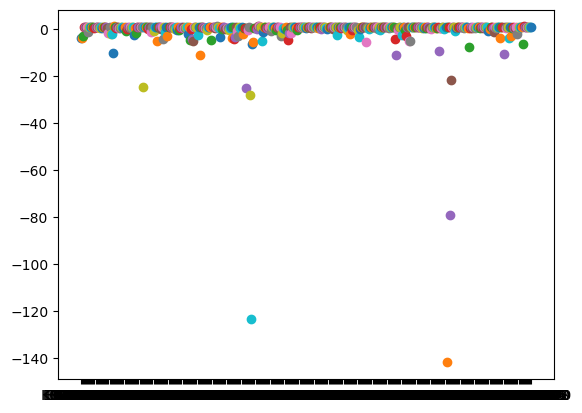

In [94]:
from sklearn import metrics

print(metrics.r2_score(data_test[data_test["geo_encoder__code_K02000001"] == 1]["remainder__next_val"], 
                                    rf_mdl.predict(select_features(data_test[data_test["geo_encoder__code_K02000001"] == 1]))))

for code in geo_data["code"]:
    plt.scatter(code, metrics.r2_score(data_test[data_test["geo_encoder__code_%s" % code] == 1]["remainder__next_val"], 
                                    rf_mdl.predict(select_features(data_test[data_test["geo_encoder__code_%s" % code] == 1]))), marker = "o")
    
plt.show()

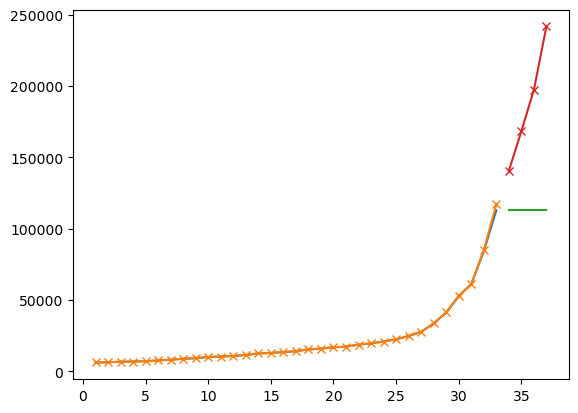

In [93]:
plt.plot(np.arange(1,34), rf_mdl.predict(select_features(data_train[data_train["geo_encoder__code_K02000001"] == 1])))
plt.plot(np.arange(1,34), data_train[data_train["geo_encoder__code_K02000001"] == 1]["remainder__next_val"], marker = "x")

plt.plot(np.arange(34,38), rf_mdl.predict(select_features(data_test[data_test["geo_encoder__code_K02000001"] == 1])))
plt.plot(np.arange(34,38), data_test[data_test["geo_encoder__code_K02000001"] == 1]["remainder__next_val"], marker = "x")

plt.show()